# Compresión de imágenes RGB

## Función para hacer check de paquetes instalados

In [19]:
import pkg_resources
import subprocess

def check_packages(package_list):
    for package_name in package_list:
        try:
            pkg_resources.get_distribution(package_name)
        except pkg_resources.DistributionNotFound:
            print(f"{package_name} no está instalado. Instalando...")
            subprocess.check_call(["pip", "install", package_name])
            print(f"{package_name} ha sido instalado correctamente.")

# packages_to_check = ['scikit-image', 'scipy', 'opencv-python']
# check_packages(packages_to_check)

# Función compress_image

¿Qué hace básicamente está función?

1. Preparación de la imagen: Toma una imagen (puede ser en escala de grises o en RGB) y la prepara para el procesamiento.

2. Descomposición Wavelet: Aplica la transformada wavelet a la imagen para obtener coeficientes de aproximación y detalles en diferentes niveles y para diferentes canales de color (si la imagen es en RGB).

3. Visualización Opcional: Ofrece la posibilidad de mostrar gráficos de los detalles y la aproximación resultante de la descomposición wavelet.

4. Compresión: Aplica un umbral a estos coeficientes wavelet, lo que esencialmente reduce la cantidad de información en la imagen.

5. Reconstrucción de la imagen: Utiliza los coeficientes modificados para reconstruir la imagen comprimida.

6. Salida y Visualización: Muestra la imagen original y la imagen reconstruida, junto con información sobre la reducción de tamaño en porcentaje.

7. Guardado Opcional: Guarda la imagen comprimida si se establece el parámetro save en True.

In [12]:
# Comprobación de paquetes
packages = ['scikit-image', 'scipy', 'opencv-python', 'numpy']
check_packages(packages)

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pywt
from PIL import Image
from skimage import exposure 
from scipy import ndimage
import os

def compress_image(image_path, wavelet = 'haar', threshold = 250, substitute = 0, orientation = "vertical", 
                   mode = "garrote", value_low = 50, value_high = 250, plot = True, equalize = True, 
                   save = True, gray = False, levels = 1, plotlevel = 1):
    
    if gray:
        img = Image.open(image_path).convert("L") # lectura como escala de grises.
        img_array = np.array(img)
        
        if orientation == 'vertical':
            img_array = np.fliplr(np.transpose(img_array, (1, 0)))  # Transponer para imágenes verticales
        else:
            img_array = img_array  # No transponer (imágenes horizontales)

        bw = img_array[:, :]
        
        def apply_wavelet_multi_level(img_array, wavelet, levels):
            coeffs = {}
            for level in range(1, levels + 1):
                coeffs_bw = pywt.wavedec2(bw, wavelet, level = level)
                coeffs[level] = (coeffs_bw)
            return coeffs
        
        coeffic = apply_wavelet_multi_level(img_array, wavelet, levels) # le he llamado coeffic porque había un problema con otra cosa que había programado antes
        
        cAnbw = coeffic[plotlevel][0] 
        
        (cHnbw, cVnbw, cDnbw) = coeffic[plotlevel][1]

        coeffs = [cAnbw, cHnbw, cVnbw, cDnbw]
        
        if plot:    
            fig, axs = plt.subplots(1, 4, figsize=(12, 8))

            axs[0].imshow(coeffs[0], cmap = "gray")
            axs[0].set_title('Approximation')

            for j, coeff in enumerate(coeffs[1:]):
                if equalize:
                    equalized_coeff = exposure.equalize_hist(coeff)
                else:
                    equalized_coeff = coeff
                    
                axs[j+1].imshow(equalized_coeff, cmap = 'gray')
                axs[j+1].set_title(f'Detail {j+1} - Level {plotlevel}')

            plt.tight_layout()
            plt.show()
        
        if mode == 'firm':
            coeffs_compressed = [pywt.threshold_firm(i, value_low = value_low, value_high = value_high) for i in coeffs]
        else:
            coeffs_compressed = [pywt.threshold(i, value=threshold, substitute = substitute, mode=mode) for i in coeffs]
    
        # Reconstrucción de canales tras la compresión
        def reconstruct_channel(cA, cH, cV, cD, wavelet_type):
            coeffs = (cA, (cH, cV, cD))
            reconstructed_channel = pywt.idwt2(coeffs, wavelet_type)
            return reconstructed_channel            
        
        reconstructed_bw = reconstruct_channel(*coeffs_compressed, wavelet)
        
        reconstructed_image = Image.fromarray(reconstructed_bw.astype('uint8'))
        
        # Ruta de guardado
        nombre_archivo = os.path.splitext(os.path.split(image_path)[1])[0] # para sacar el nombre antes de la extensión... me es útil en otra parte
        
        output_image_path = os.path.splitext(image_path)[0]
        original_extension = os.path.splitext(image_path)[1]
        output_image_path = f"{output_image_path}_{wavelet}_{mode}_{threshold}{original_extension}"

        reconstructed_image.save(output_image_path)
             
        # Tamaños de imágenes original y reconstruida con su reducción
        original_size = os.path.getsize(image_path) / 1024  # tamaño inicial en KB de la imagen
        reconstructed_size = os.path.getsize(output_image_path) / 1024  # tamaño final en KB de la imagen
        reduction_percentage = ((original_size - reconstructed_size) / original_size) * 100 # reducción de tamaño en porcentaje
        
        if not save:
            os.remove(output_image_path) # útil por si no queremos acumular imágenes y solo queremos el tamaño
    
        # Figura en sí
        if plot:
        
            fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
            axes[0].imshow(img_array, cmap = "gray")
            axes[0].set_title(f'Imagen original')
            axes[0].axis('off')
            axes[0].annotate(f'Tamaño: {original_size:.2f} KB', xy = (0.5, -0.1), xycoords="axes fraction", ha = 'center', va = 'center')

    
            axes[1].imshow(reconstructed_image, cmap = "gray")
            axes[1].set_title(f'Imagen modificada')
            axes[1].axis('off')
            axes[1].annotate(f'Tamaño: {reconstructed_size:.2f} KB \nWavelet: {wavelet} \nThreshold: {threshold} \nMode: {mode}', xy=(0.5, -0.1), xycoords="axes fraction", ha = 'center', va = 'center')
    
            reduction_text = f'Reducción: {reduction_percentage:.2f}%'
            plt.figtext(0.5, 0, reduction_text, ha = 'center', va = 'center')

            plt.tight_layout()
            plt.show()
                     
    else:
        # Carga de la imagen RGB
        img = Image.open(image_path)
        img_array = np.array(img)
    
        if orientation == 'vertical':
            img_array = np.fliplr(np.transpose(img_array, (1, 0, 2)))  # Transponer para imágenes verticales
        else:
            img_array = img_array  # No transponer (imágenes horizontales)
    
    
        # Separar canales RGB de la imagen
        r, g, b = img_array[:, :, 0], img_array[:, :, 1], img_array[:, :, 2]

        # Aplicar wavelet en cada canal y hallar coeficientes
        
        def apply_wavelet_multi_level(img_array, wavelet, levels):
            coeffs = {}
            for level in range(1, levels + 1):
                coeffs_r = pywt.wavedec2(r, wavelet, level = level)
                coeffs_g = pywt.wavedec2(g, wavelet, level = level)
                coeffs_b = pywt.wavedec2(b, wavelet, level = level)
                coeffs[level] = (coeffs_r, coeffs_g, coeffs_b)
            return coeffs
        
        coeffic = apply_wavelet_multi_level(img_array, wavelet, levels) # le he llamado coeffic porque había un problema con otra cosa que había programado antes
        
        cAnr = coeffic[plotlevel][0][0] 
        cAng = coeffic[plotlevel][1][0]
        cAnb = coeffic[plotlevel][2][0]
        
        (cHnr, cVnr, cDnr) = coeffic[plotlevel][0][1]
        (cHng, cVng, cDng) = coeffic[plotlevel][1][1]
        (cHnb, cVnb, cDnb) = coeffic[plotlevel][2][1]
        
        r_coeffs = [cAnr, cHnr, cVnr, cDnr]
        g_coeffs = [cAng, cHng, cVng, cDng]
        b_coeffs = [cAnb, cHnb, cVnb, cDnb]
        
    # Ver gráfico de aproximación y detalles
    
        if plot:
            fig, axs = plt.subplots(3, 4, figsize = (12, 8))

            for i, coeffs in enumerate([r_coeffs, g_coeffs, b_coeffs]):

                axs[i, 0].imshow(coeffs[0], cmap = "gray")
                axs[i, 0].set_title(f'{["R", "G", "B"][i]} - Approximation')

        # Contraste mejorado con exposusure.equalize_hist
    
                for j, coeff in enumerate(coeffs[1:]):
                    if equalize:
                        equalized_coeff = exposure.equalize_hist(coeff)
                    else:
                        equalized_coeff = coeff
                               
                    axs[i, j+1].imshow(equalized_coeff, cmap='gray')
                    axs[i, j+1].set_title(f'{["R", "G", "B"][i]} - Detail {j+1} - Level {plotlevel}')

            plt.tight_layout()
            plt.show()

    # Meter threshold en coeficientes para la compresión
        if mode == 'firm':
            r_coeffs_compressed = [pywt.threshold_firm(i, value_low = value_low, value_high = value_high) for i in r_coeffs]
            g_coeffs_compressed = [pywt.threshold_firm(i, value_low = value_low, value_high = value_high) for i in g_coeffs]
            b_coeffs_compressed = [pywt.threshold_firm(i, value_low = value_low, value_high = value_high) for i in b_coeffs]
        else:
            r_coeffs_compressed = [pywt.threshold(i, value=threshold, substitute = substitute, mode=mode) for i in r_coeffs]
            g_coeffs_compressed = [pywt.threshold(i, value=threshold, substitute = substitute, mode=mode) for i in g_coeffs]
            b_coeffs_compressed = [pywt.threshold(i, value=threshold, substitute = substitute, mode=mode) for i in b_coeffs]

        # Reconstrucción de canales tras la compresión
        def reconstruct_channel(cA, cH, cV, cD, wavelet_type):
            coeffs = (cA, (cH, cV, cD))
            reconstructed_channel = pywt.idwt2(coeffs, wavelet_type)
            return reconstructed_channel

    # Reconstrucción de la imagen a partir de los coeficientes comprimidos
    
        reconstructed_r = reconstruct_channel(*r_coeffs_compressed, wavelet)
        reconstructed_g = reconstruct_channel(*g_coeffs_compressed, wavelet)
        reconstructed_b = reconstruct_channel(*b_coeffs_compressed, wavelet)

        # Reconstrucción de la imagen a partir de los canales
        reconstructed_image = np.stack((reconstructed_r, reconstructed_g, reconstructed_b), axis=-1)
        reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8)
        
        # Ruta de guardado
        nombre_archivo = os.path.splitext(os.path.split(image_path)[1])[0] # para sacar el nombre antes de la extensión... me es útil en otra parte
        
        output_image_path = os.path.splitext(image_path)[0]
        original_extension = os.path.splitext(image_path)[1]
        output_image_path = f"{output_image_path}_{wavelet}_{mode}_{threshold}{original_extension}"

        reconstructed_image = Image.fromarray(reconstructed_image.astype('uint8'))
        reconstructed_image.save(output_image_path)
        
        # Tamaños de imágenes original y reconstruida con su reducción
        original_size = os.path.getsize(image_path) / 1024  # tamaño inicial en KB de la imagen
        reconstructed_size = os.path.getsize(output_image_path) / 1024  # tamaño final en KB de la imagen
        reduction_percentage = ((original_size - reconstructed_size) / original_size) * 100 # reducción de tamaño en porcentaje

        if not save:
            os.remove(output_image_path) # útil por si no queremos acumular imágenes y solo queremos el tamaño
    
    # Figura en sí
        if plot:
            
            fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
            axes[0].imshow(img_array)
            axes[0].set_title(f'Imagen original')
            axes[0].axis('off')
            axes[0].annotate(f'Tamaño: {original_size:.2f} KB', xy = (0.5, -0.1), xycoords="axes fraction", ha = 'center', va = 'center')
    
        
            axes[1].imshow(reconstructed_image)
            axes[1].set_title(f'Imagen modificada')
            axes[1].axis('off')
            axes[1].annotate(f'Tamaño: {reconstructed_size:.2f} KB \nWavelet: {wavelet} \nThreshold: {threshold} \nMode: {mode}', xy=(0.5, -0.1), xycoords="axes fraction", ha = 'center', va = 'center')
        
            reduction_text = f'Reducción: {reduction_percentage:.2f}%'
            plt.figtext(0.5, 0, reduction_text, ha = 'center', va = 'center')
    
            plt.tight_layout()
            plt.show()

    return nombre_archivo, original_extension, output_image_path, reduction_percentage, reconstructed_image, coeffic

# Uso de la función con valores por defecto


# familias útiles: ['haar', 'db2', 'dmey', ]

# Importante: para acceder a coeficientes deseados se sigue así:
# coeffs[plotlevel][color][0] -> coeficiente de aproximación de orden plotlevel para el color dado por {rojo = 0, blue = 1, green = 2}
# coeffs[plotlevel][color][1] -> tupla de 3 elementos (vectores) para detalles de orden plotlevel para el color dado por {rojo = 0, blue = 1, green = 2}
# coeffs[plotlevel][color][2] -> tupla de 3 elementos (vectores) para detalles de orden (plotlevel - 1) para el color dado por {rojo = 0, blue = 1, green = 2}, ETC.

# Ejemplillo: quiero conseguir cuáles son los coeficientes de detalle de orden 3 para el rojo
# coeffs[3][0][1] (también valdría algo más turbio como coeffs[4][0][2] en teoría, pero bueno)... Esto da una tupla de 3 elementos. 
# Si se quiere desempaquetar se hace (cH3r, cV3r, cD3r) = coeffs[3][0][1] y se tendrían los 3 por separado si se quiere

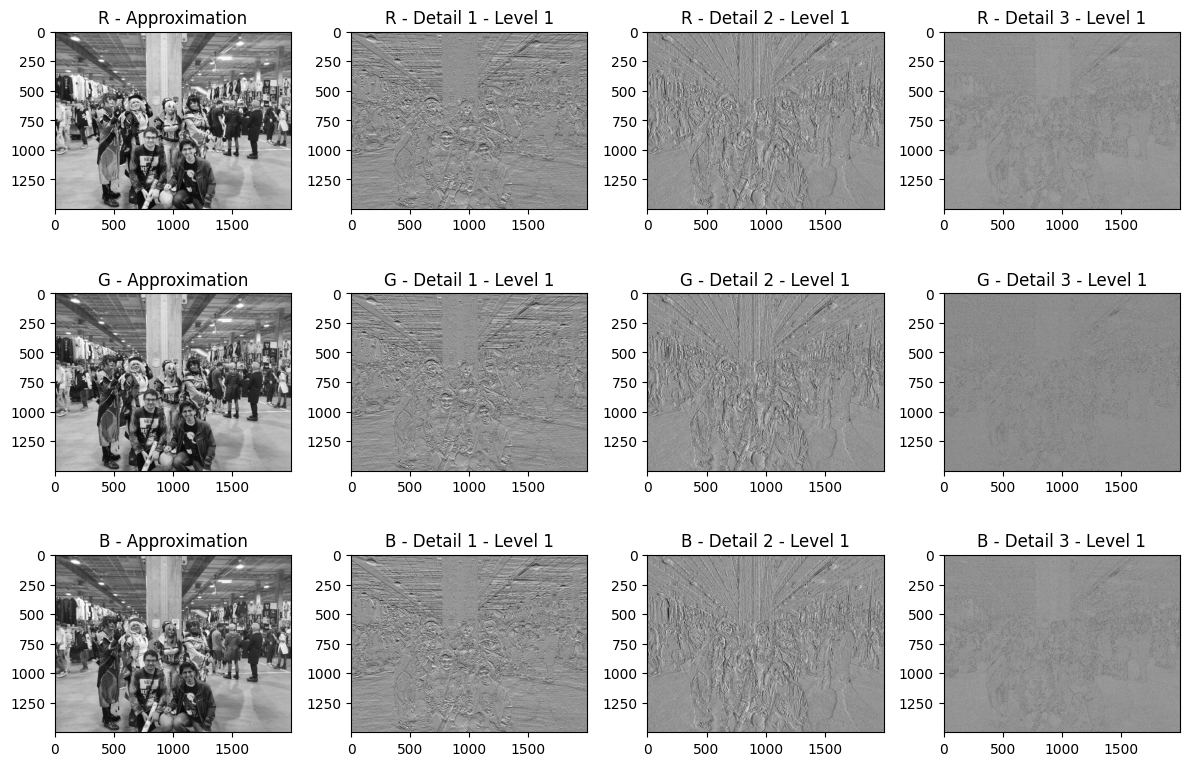

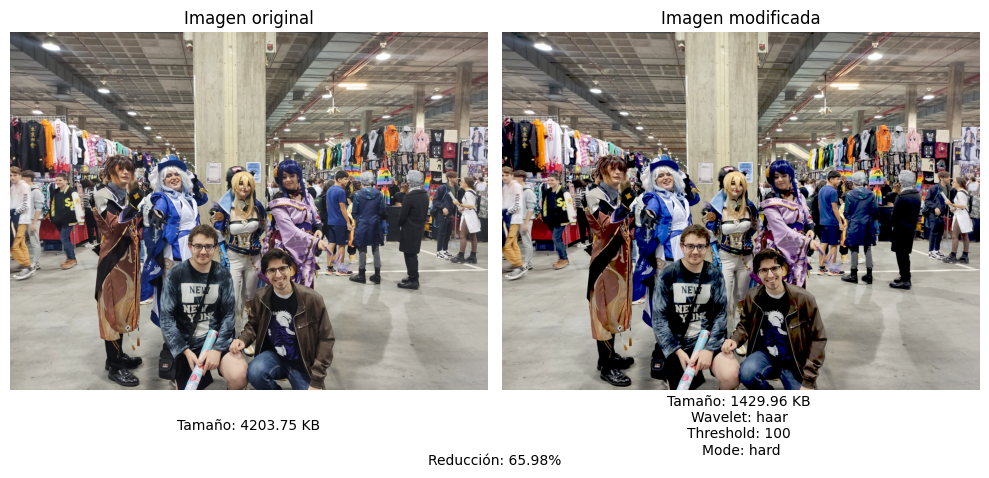

In [4]:
nombre_archivo, original_extension, output_image_path, reduction_percentage, reconstructed, coeffs = compress_image(image_path = './data/genshin.jpg', wavelet = 'haar', threshold = 100, 
                                                                                substitute = 0, orientation = "horizontal", 
                                                                                mode = "hard", value_low = 50, value_high = 250, plot = True, 
                                                                                equalize = True, save = False, gray = False, levels = 4, plotlevel = 1)


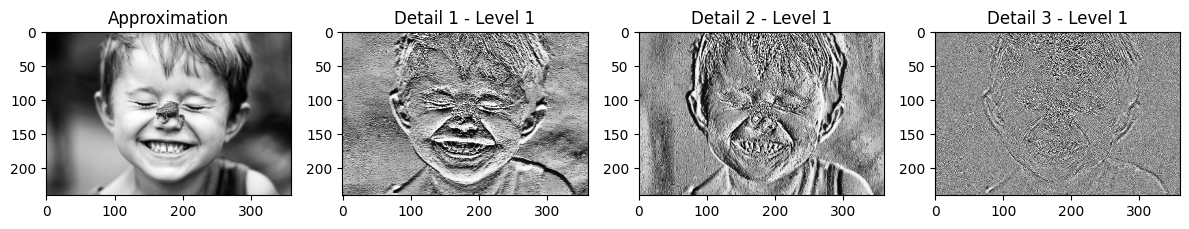

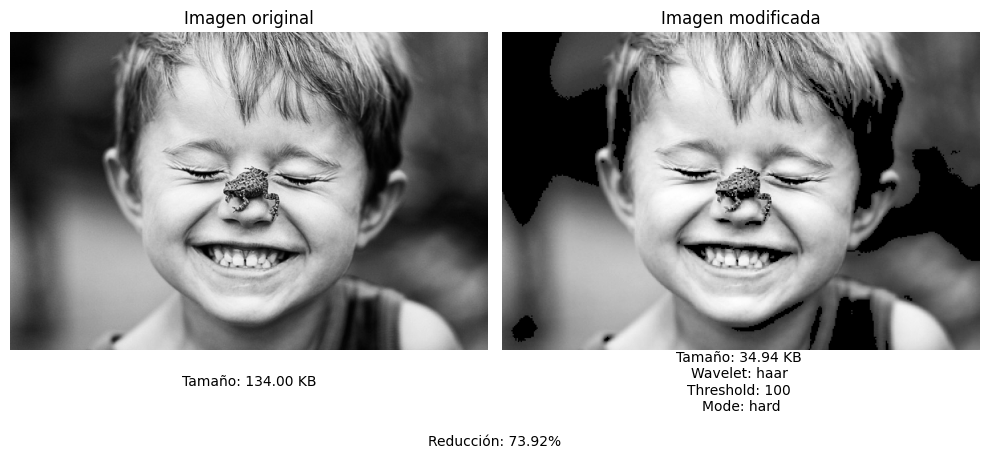

In [10]:
nombre_archivo, original_extension, output_image_path, reduction_percentage, reconstructed, coeffs = compress_image(image_path = './data/nino.jpg', wavelet = 'haar', threshold = 100, 
                                                                                substitute = 0, orientation = "horizontal", 
                                                                                mode = "hard", value_low = 50, value_high = 250, plot = True, 
                                                                                equalize = True, save = False, gray = True, levels = 4, plotlevel = 1)

# Información acerca de cómo funcionan los distintos modos de pywt.threshold

## Modes

Entrada: array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ])   

### Soft thresholding.

Establece en cero (o el valor colocado en *substitute*) los coeficientes cuya magnitud sea menor que el valor umbral (value), reduciendo además el resto de determinada manera.

**Ejemplo:**  
pywt.threshold(data, 2, 'soft')  
Salida: array([ 0. ,  0. ,  0. ,  0.5,  1. ,  1.5,  2. ])  

Estrictamente: data/np.abs(data) * np.maximum(np.abs(data) - value, 0).

### Hard thresholding.

Establece en cero (o el valor colocado en *substitute*) los coeficientes cuya magnitud sea menor que el umbral, manteniendo intactos los otros.  

**Ejemplo:**  
pywt.threshold(data, 2, 'hard')  
array([ 0. ,  0. ,  2. ,  2.5,  3. ,  3.5,  4. ])

### Greater or less thresholding.

Establecen en cero (o el valor colocado en *substitute*) los coeficientes cuya magnitud sea mayor o menor que el valor umbral, respectivamente.  

**Ejemplo:**  
pywt.threshold(data, 2, 'greater')  
array([ 0. ,  0. ,  2. ,  2.5,  3. ,  3.5,  4. ])  

pywt.threshold(data, 2, 'less')  
array([ 1. ,  1.5,  2. ,  0. ,  0. ,  0. ,  0. ])  

### Garrote thresholding.

Se comporta de manera intermedia a *hard* y *soft*. Para valores pequeños es como *soft* y para valores muy grandes se aproxima cada vez más a *hard*.  

**Ejemplo:**  
pywt.threshold(data, 2, 'garrote')  
array([ 0.,  0.,  0. ,  0.9,  1.66666667, 2.35714286,  3.])  

# Código para comparación entre distintos tipos de wavelets, threshold values y modos

Básicamente aquí se pueden establecer vectores para distintos wavelets, valores de umbral y modos de threshold

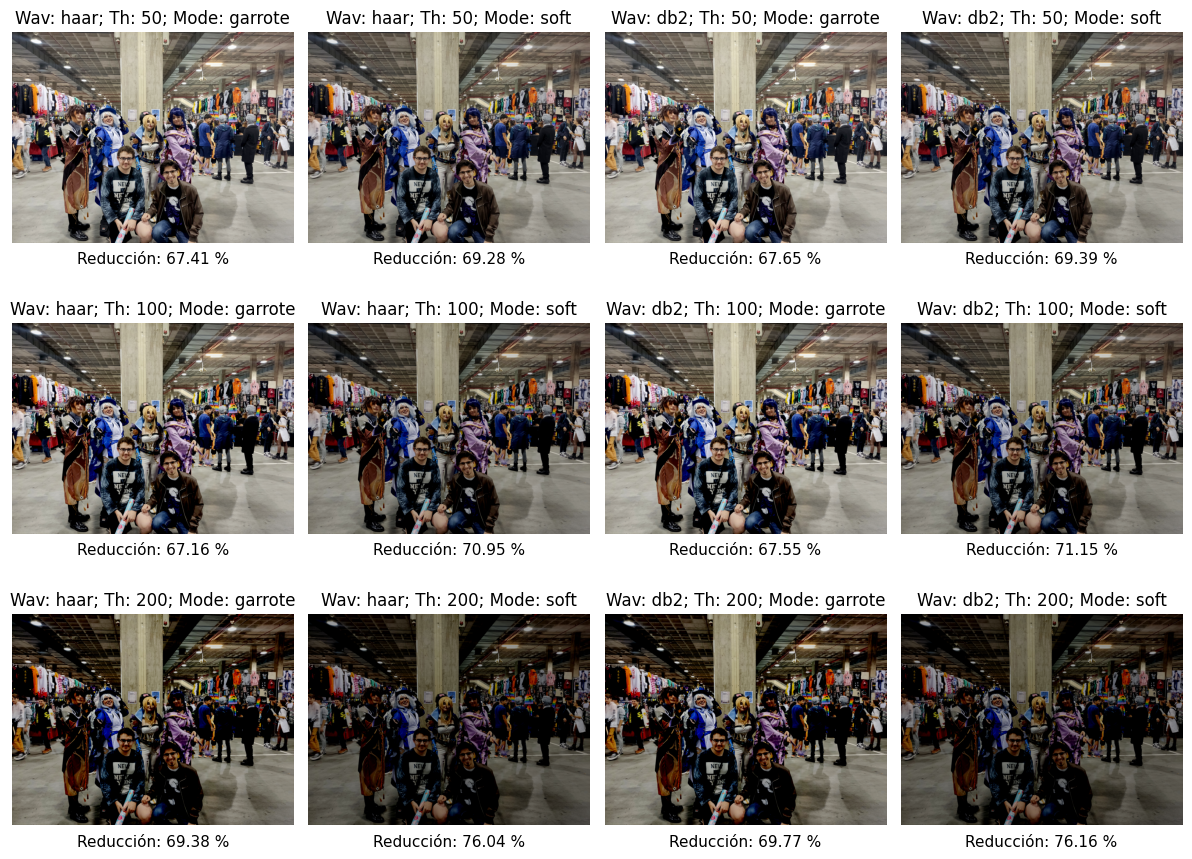

In [20]:
# Listas de parámetros a probar

wavelet_families = ['haar', 'db2']  # Ejemplo de familias de wavelets a probar
threshold_values = [50, 100, 200]  # Ejemplo de valores de threshold a probar
modes = ['garrote', 'soft']  # Ejemplo de modos a probar

num_rows = len(threshold_values)
num_cols = len(wavelet_families) * len(modes)

fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (12, 9))


for i, threshold in enumerate(threshold_values):
    for j, wavelet in enumerate(wavelet_families):
        for k, mode in enumerate(modes):
            _, _, output_image_path, reduction_percentage, reconstructed, _ = compress_image(image_path = './data/genshin.jpg', wavelet = wavelet, threshold = threshold, mode = mode, substitute = 0, orientation = "horizontal", value_low = 50, value_high = 250, plot = False, save = False)
            col_index = j * len(modes) + k
            ax = axes[i, col_index]
            ax.imshow(reconstructed)
            ax.set_title(f'Wav: {wavelet}; Th: {threshold}; Mode: {mode}')
            ax.annotate(f'Reducción: {reduction_percentage:.2f} %', xy = (0.5, -0.1), xycoords = 'axes fraction', ha = 'center', fontsize = 11)
            ax.axis('off')

plt.tight_layout()

plt.savefig('./data/genshin_plot.jpg', dpi = 300)
plt.show()

# Obtener el threshold adecuado para una reducción buscada de calidad (familia, modo fijas)

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

def find_optimal_threshold(image_path, target_reduction = 80, threshold_ini = 200, wavelet = 'haar', mode = 'garrote', max_iterations = 10, tolerance = 3, step_size = 10, orientation = "vertical", adaptative = True, initial_range = False, gray = False):
    
    img = Image.open(image_path)
    original_size = os.path.getsize(image_path) / 1024  # Tamaño original en KB
    current_reduction = 0
    results = []
    
    if initial_range:
        if (target_reduction >= 65):
            threshold = 250
        elif (target_reduction >= 30 and target_reduction < 65):
            threshold = 150
        else:
            threshold = 100
    else:
        threshold = threshold_ini # valor más o menos medio

    default_step_size = step_size
    
    for it in range(1, max_iterations + 1):
        _, _, output_image_path, _, reconstructed, _ = compress_image(image_path, wavelet = wavelet, threshold = threshold, mode = mode, plot = False, orientation = orientation, save = True, gray = gray)
        reconstructed_size = os.path.getsize(output_image_path) / 1024  # Tamaño de la imagen comprimida en KB
        current_reduction = ((original_size - reconstructed_size) / original_size) * 100

        if abs(current_reduction - target_reduction) < tolerance:
            #print(f"Iteración: {it}, Reducción actual: {current_reduction:.2f} %, Umbral actual: {threshold}")
            print("Alcanzada la reducción deseada dentro del margen de tolerancia.")
            results.append([it, current_reduction, threshold])
            break  # Si se alcanza la compresión deseada dentro de la tolerancia, salir del bucle
        
        #print(f"Iteración: {it}, Reducción actual: {current_reduction:.2f} %, Umbral actual: {threshold}")
        results.append([it, current_reduction, threshold])
        
        os.remove(output_image_path)
        
        # Paso adaptativo
        if adaptative:
            if current_reduction * 1.2 < target_reduction or current_reduction * 0.8 > target_reduction:  # Comprobar la condición adicional
                step_size *= 1.3  # Modificar step_size si se cumple la condición
            else:
                step_size = default_step_size  # Restaurar el valor predeterminado de step_size
            
        # Ajustar el umbral para la siguiente iteración
        if current_reduction < target_reduction:
            threshold += step_size
        else:
            threshold -= step_size
            
    table = pd.DataFrame(results)
    table.columns = ['Iteration', 'Reduction (%)', 'Threshold']
    
    return table, reconstructed, target_reduction, wavelet, mode, threshold

In [24]:
max_iterations = 20

tabla, reconstructed, target_reduction, wavelet, mode, threshold = find_optimal_threshold('./data/genshin.jpg', target_reduction = 85, threshold_ini = 200, wavelet = "haar", max_iterations = max_iterations, mode = "garrote", orientation = "horizontal", step_size = 10, adaptative = True, initial_range = False, gray = False) # adaptative = True permite reducir núm de iteraciones; initial_range establecido un poco a ojo
tabla.head(n = max_iterations)

Alcanzada la reducción deseada dentro del margen de tolerancia.


Iteration  Reduction (%)  Threshold
0           1      69.380947      200.0
1           2      70.247547      213.0
2           3      71.594373      229.9
3           4      72.444386      239.9
4           5      73.367761      249.9
5           6      74.352722      259.9
6           7      75.391415      269.9
7           8      76.490020      279.9
8           9      77.594874      289.9
9          10      78.698683      299.9
10         11      79.786068      309.9
11         12      80.860653      319.9
12         13      81.941649      329.9
13         14      83.110690      339.9

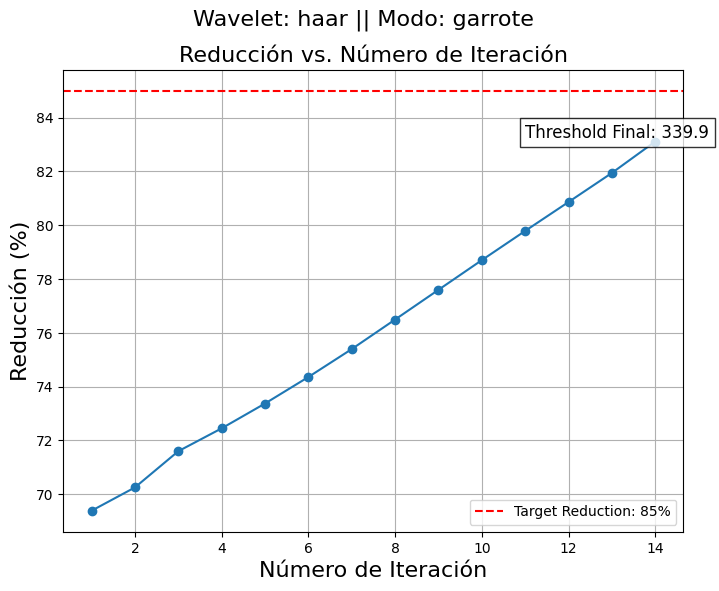

In [25]:
iteraciones = tabla['Iteration']
reducciones = tabla['Reduction (%)']

# Graficar la reducción frente al número de iteración
plt.figure(figsize = (8, 6))
plt.plot(iteraciones, reducciones, marker = 'o', linestyle = '-')
plt.axhline(y = target_reduction, color = 'r', linestyle = '--', label = f'Target Reduction: {target_reduction}%')
plt.title('Reducción vs. Número de Iteración', fontsize = 16)
plt.xlabel('Número de Iteración', fontsize = 16)
plt.ylabel('Reducción (%)', fontsize = 16)
plt.legend()
info_text = f'Wavelet: {wavelet} || Modo: {mode}'
plt.suptitle(info_text, ha = 'center', fontsize = 16)

# Encontrar las coordenadas del último punto
ultimo_punto = (iteraciones.iloc[-1], reducciones.iloc[-1])
plt.text(ultimo_punto[0] - 3, ultimo_punto[1] - 0, f'Threshold Final: {np.round(threshold, 2)}', fontsize = 'large', ha = 'left', va = 'bottom', bbox = dict(facecolor='white', alpha=0.8))

plt.grid(True)
plt.show()

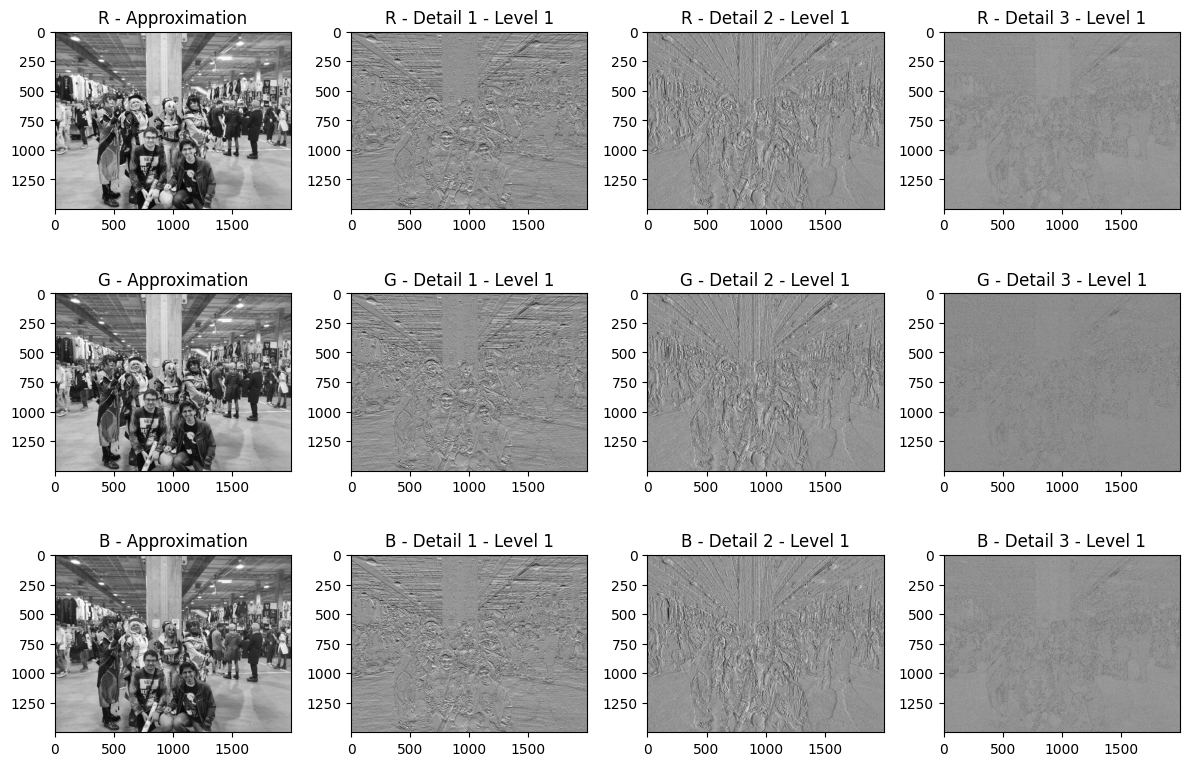

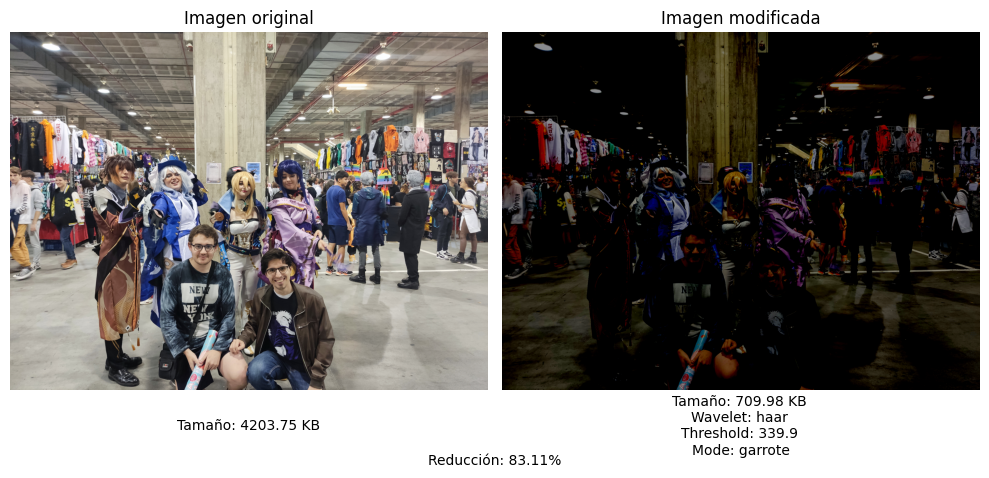

In [26]:
nombre_archivo, original_extension, output_image_path, reduction_percentage, reconstructed, coeffs = compress_image(image_path = './data/genshin.jpg', wavelet = wavelet, threshold = threshold, 
                                                                                substitute = 0, orientation = "horizontal", 
                                                                                mode = mode, value_low = 50, value_high = 250, plot = True, 
                                                                                equalize = True, save = False, gray = False, levels = 4, plotlevel = 1)

# Aplicación de compresión a una carpeta de nuestras imágenes

In [18]:
import os

# Obtener la lista de archivos en la carpeta
carpeta = './data/pack' 
lista_archivos = sorted(os.listdir(carpeta), key = lambda x: os.path.getmtime(os.path.join(carpeta, x)))
carpeta_dest = "./data/pack_comprimido/"

if not os.path.exists(carpeta_dest):
    os.makedirs(carpeta_dest)

wavelet = "haar"
threshold = 200
mode = "hard"
gray = False

for archivo in lista_archivos:
    
    if archivo.endswith(".jpg") or archivo.endswith(".png"):
        
        image_path = os.path.join(carpeta, archivo)
        nombre_archivo, original_extension, output_image_path, reduction_percentage, reconstructed, coeffs = compress_image(image_path = image_path, wavelet = wavelet, threshold = threshold, 
                                                                                mode = mode, orientation = "horizontal", plot = False, save = False)
        output_image_path = f"{carpeta_dest}{nombre_archivo}_{wavelet}_{mode}_{threshold}{original_extension}"
        
        if gray:
            reconstructed.save(output_image_path)
        else:
            reconstructed.save(output_image_path)

           
def obtener_tamano_carpeta(ruta_carpeta):
    tamano_total = 0
    for ruta, directorios, archivos in os.walk(ruta_carpeta):
        for archivo in archivos:
            ruta_archivo = os.path.join(ruta, archivo)
            tamano_total += os.path.getsize(ruta_archivo)
    return tamano_total / 1024


tamano_carpeta_original = obtener_tamano_carpeta(carpeta)
tamano_carpeta_dest = obtener_tamano_carpeta(carpeta_dest) if os.path.exists(carpeta_dest) else 0

reduccion = ((tamano_carpeta_original - tamano_carpeta_dest) / tamano_carpeta_original) * 100 if tamano_carpeta_original > 0 else 0

print("Información de tamaño:")
print("---------------------")
print(f"Tamaño de la carpeta original: {tamano_carpeta_original:.2f} KB")
print(f"Tamaño de la carpeta de destino: {tamano_carpeta_dest:.2f} KB")
print(f"Reducción en tamaño: {reduccion:.2f}%")

Información de tamaño:
---------------------
Tamaño de la carpeta original: 386.34 KB
Tamaño de la carpeta de destino: 199.25 KB
Reducción en tamaño: 48.43%
